In [1]:
# If you're running this on the same machine as the backend server,
#  you do not need to establish an SSH tunnel

SERVER_URL = "http://127.0.0.1:3000"

In [2]:
from numpy import random
import requests

DELTA_TIME = 0.01

STOP = 0
X_GO = 1
Y_GO = 2

YELLOW_LIGHT_TIME = 6

MAX_CAR_FLOW_RATE = 0.5

def get_next_car(gamma):
    # Assume cars approach the intersection under an exponential distribution
    return random.exponential(gamma, size=1)[0]

class TrafficLight:
    def __init__(self, x_rate, y_rate):
        # https://en.wikipedia.org/wiki/Exponential_distribution#Mean:~:text=1
        self.x_rate_gamma = 1 / x_rate
        self.y_rate_gamma = 1 / y_rate
        self.x_timer = get_next_car(self.x_rate_gamma)
        self.y_timer = get_next_car(self.y_rate_gamma)
        
        self.x_cars = 0
        self.y_cars = 0
        
        self.time = 0
        self.prev_state = STOP
        self.state = X_GO
        self.transition_timer = 0
        self.momentum = 0
    
    def tick(self):
        self.x_timer -= DELTA_TIME
        self.y_timer -= DELTA_TIME
        self.transition_timer -= DELTA_TIME
        
        # Spawn new cars
        if self.x_timer < 0:
            self.x_cars += 1
            self.x_timer = get_next_car(self.x_rate_gamma)
        if self.y_timer < 0:
            self.y_cars += 1
            self.y_timer = get_next_car(self.y_rate_gamma)
        
        # Update momentum (Cars go slow when light first turns green)
        self.momentum = min(self.momentum + (0.05 * DELTA_TIME), MAX_CAR_FLOW_RATE)
        
        # Let cars leave
        if self.state == X_GO:
            self.x_cars = max(self.x_cars - (self.momentum * DELTA_TIME), 0)
        if self.state == Y_GO:
            self.y_cars = max(self.y_cars - (self.momentum * DELTA_TIME), 0)
        
        # Swap lights
        if self.transition_timer < 0:
            old_state = self.state
            if self.state == X_GO or self.state == Y_GO:
                self.state = STOP
                self.transition_timer = YELLOW_LIGHT_TIME
            elif self.state == STOP:
                self.state = X_GO if self.prev_state == Y_GO else Y_GO
                x = requests.get(f"{SERVER_URL}/get_light_times")
                self.transition_timer = int(x.text)
                
            self.prev_state = old_state
            self.momentum = 0
            
        self.time += DELTA_TIME

In [6]:
X_RATE = 0.05 # Cars per second
Y_RATE = 0.20 # Cars per second

SIMULATION_TIME = 1000
total_ticks = int(SIMULATION_TIME / DELTA_TIME)

tl = TrafficLight(X_RATE, Y_RATE)
x_cars = []
y_cars = []
times  = []
states = []
for i in range(total_ticks):
    tl.tick()
    
    # Keep track of certain metrics to plot later
    x_cars.append(tl.x_cars)
    y_cars.append(tl.y_cars)
    states.append(tl.state)
    times.append(tl.time)    # X-axis

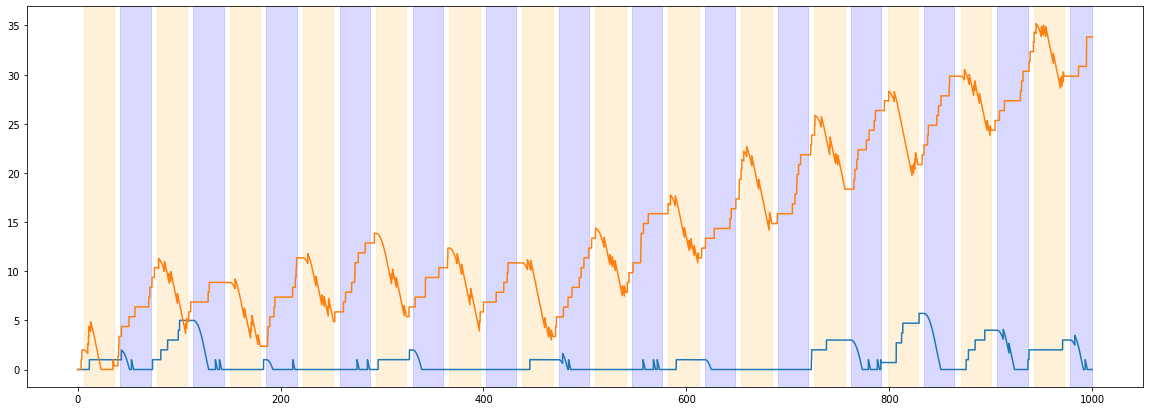

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,7)) 


###### GET REGIONS (SEGMENTS) OF X_GO AND Y_GO #######
segments = []
start_index = 0
index = 0
value = states[0]
while True:
    if index >= len(states):
        if not value == STOP: 
            segments.append((start_index, index))
        break
    
    if states[index] != value:
        if not value == STOP: 
            segments.append((start_index, index))
        
        value = states[index]
        start_index = index
    
    index += 1
    
###### SET BACKGROUNDS OF PLOT ######
for i in range(len(segments)):
    col = "orange" if i % 2 == 0 else "blue"
    plt.axvspan(segments[i][0] * DELTA_TIME, segments[i][1] * DELTA_TIME, color=col, alpha=0.15)
    
plt.plot(times, x_cars)
plt.plot(times, y_cars)

plt.show()

In [1]:
DENSITY_MAX = 300.0
V_MAX = 20.0

def speed_density_func(density):
    V_MAX = 20.0
    SLOPE_SEG_1 = -0.01
    TRANSITION_SEG_1_TO_2 = 100.0
    TRANSITION_SEG_2_TO_3 = 180.0
    SPEED_TRANSITION_2_TO_3 = 2.5
    
    SPEED_TRANSITION_1_TO_2 = V_MAX + (SLOPE_SEG_1 * TRANSITION_SEG_1_TO_2)
    SLOPE_SEG_2 = (SPEED_TRANSITION_2_TO_3 - SPEED_TRANSITION_1_TO_2) / (TRANSITION_SEG_2_TO_3 - TRANSITION_SEG_1_TO_2)
    
    SLOPE_SEG_3 = (0 - SPEED_TRANSITION_2_TO_3) / (DENSITY_MAX - TRANSITION_SEG_2_TO_3)
    
    if density < TRANSITION_SEG_1_TO_2:
        return V_MAX + (SLOPE_SEG_1 * density)
    elif density < TRANSITION_SEG_2_TO_3:
        SEG_2_Y_INTERCEPT = (SLOPE_SEG_2 * (0 - TRANSITION_SEG_1_TO_2)) + SPEED_TRANSITION_1_TO_2
        return SEG_2_Y_INTERCEPT + (SLOPE_SEG_2 * density)
    else:
        SEG_3_Y_INTERCEPT = (SLOPE_SEG_3 * (0 - TRANSITION_SEG_2_TO_3)) + SPEED_TRANSITION_2_TO_3
        return SEG_3_Y_INTERCEPT + (SLOPE_SEG_3 * density)
    
# def speed_density_func(density):
#     return V_MAX * (1 - (1.0 / DENSITY_MAX))

In [5]:
import numpy as np
from matplotlib import pyplot as plt

x = np.arange(0, 300)
y = np.zeros(300)
for i in range(len(x)):
    y[i] = speed_density_func(x[i])
    
plt.plot(x,y)

In [6]:
LENGTH = 1000
SPATIAL_SEGMENTS = 100
DELTA_X = LENGTH / SPATIAL_SEGMENTS
x = np.arange(SPATIAL_SEGMENTS) # Cars / Meter
p = (10 * np.sin(x * 0.4)) + 30

In [7]:
plt.plot(x,p)
plt.show()

In [8]:
def tick(p, dt):
    p_next = np.zeros(len(p))
    for i in range(len(p)):
        prev_cell_index = i - 1
        cell_index      = i
        next_cell_index = i + 1
        
        prev_density = p[prev_cell_index]
        cell_density = p[cell_index]
        next_density = p[next_cell_index % len(p)]
        
        prev_speed = speed_density_func(prev_density)
        cell_speed = speed_density_func(cell_density)
        next_speed = speed_density_func(next_density)
        
        if prev_cell_index < 0:
            prev_density = 10
            prev_speed = speed_density_func(prev_density)
        if next_cell_index >= len(p):
            next_density = 10
            next_speed = speed_density_func(next_density)
            
        ALPHA = 0.2
            
        cell_speed = ((1-ALPHA) * cell_speed) + (ALPHA * next_speed)      
        change_in_speed = ((next_speed - cell_speed) + (cell_speed - prev_speed)) / (2 * DELTA_X)
            
        flux = p[i] * (change_in_speed * dt)
        
        p_next_i = p[i] + flux
#         if i-1 > 0:
#             p_next[i-1] -= flux
        p_next[i] = max(min(p_next_i, DENSITY_MAX), 0)
    return p_next

<IPython.core.display.Javascript object>


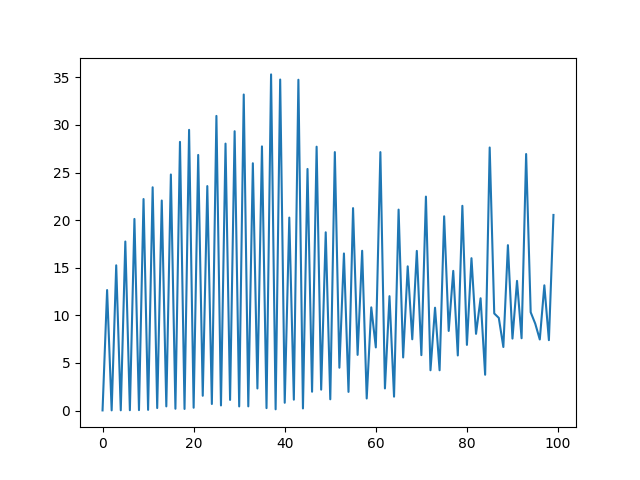

In [9]:
%matplotlib notebook
DELTA_TIME = 0.1

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    for i in range(1000):
        p = tick(p, DELTA_TIME)
    ax.clear()
    ax.plot(x,p)
    fig.canvas.draw()
